# Import a benchmark datasets, Examine BERT embeddings, Break down a `pipeline()`, Look at multi-class classification with a fine-tuned model.

### `pip install` necessary packages, then restart runtime.

In [1]:
# uncomment lines below, run this cell, then restart the runtime before continuing
# !pip install transformers > out1
# !pip install datasets > out2
# !pip install numpy==1.23.4 > out3
# !pip install -U torch > out4
# !pip install sentencepiece

In [2]:
import numpy as np
import time
import pandas as pd
from transformers import pipeline, AutoConfig, AutoModel, AutoTokenizer
from datasets import load_dataset
import torch 

### Import a Common Dataset: Movie Reviews / Rotten Tomatoes

* `rotten_tomatoes` dataset details: [Hugging Face Dataset card](https://huggingface.co/datasets/rotten_tomatoes)  
* Original Paper: [Seeing Stars: Exploiting Class Relationships for Sentiment Categorization with Respect to Rating Scales (Pang and Lee 2005)](https://aclanthology.org/P05-1015/)

In [3]:
rt_dataset = load_dataset('rotten_tomatoes')
rt_dataset

Found cached dataset rotten_tomatoes (/home/dspuser/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

Examine a negative and a positive example from the `rotten_tomatoes` dataset

In [4]:
# positive review:
print(rt_dataset['train'][0])
print()
# negative review:
print(rt_dataset['train'][-7])

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}

{'text': "snoots will no doubt rally to its cause , trotting out threadbare standbys like 'masterpiece' and 'triumph' and all that malarkey , but rarely does an established filmmaker so ardently waste viewers' time with a gobbler like this .", 'label': 0}


Split into train, validation, and test sets for later use.

In [5]:
train_dataset, val_dataset, test_dataset = load_dataset('rotten_tomatoes', split=['train', 'validation', 'test'])

Found cached dataset rotten_tomatoes (/home/dspuser/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)


  0%|          | 0/3 [00:00<?, ?it/s]

### Transformer Tokenization

Goal: gain an understanding for how tokenization works in the `transformers` library.

Every pretrained model comes with its own tokenizer.  Since we will be using BERT from the `transformers` library, we should also use its accompanying tokenizer.  Specifically, we are using the ``bert-base-uncased`` model.  You can read more about it [here](https://huggingface.co/bert-base-uncased).  Run the following cell to import the relevant tokenizer from `transformers`.  You can read more about the `transformers` `Tokenizer` class [here](https://huggingface.co/docs/transformers/main_classes/tokenizer#tokenizer).

In [6]:
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

Next, run the following cell to see how the tokenizer can be used to tokenize our text.

In [7]:
example_text = ["I'm not sure why plebes at USMA must refrain from speaking outside.  It makes no sense.",
           "I really enjoy sunbathing on the roof of MacArthur barracks."]
tokenized_example_text = tokenizer(example_text, truncation=True, padding=True, return_tensors='pt')

The object `tokenized_text` is a custom object from the `transformer` library.  It has a `__getitem__` function, so you can index into it.  For example, `tokenized_example_text[0]` gets the first tokenized example.  As an example, you can get the tokens and integer representations of the first tweet by running the cell below.

In [8]:
print(tokenized_example_text[0].tokens)
print(tokenized_example_text[0].ids)
print()
print(tokenized_example_text[1].tokens)
print(tokenized_example_text[1].ids)
print(f'\nVocab size: {tokenizer.vocab_size}')

['[CLS]', 'i', "'", 'm', 'not', 'sure', 'why', 'pl', '##eb', '##es', 'at', 'us', '##ma', 'must', 'refrain', 'from', 'speaking', 'outside', '.', 'it', 'makes', 'no', 'sense', '.', '[SEP]']
[101, 1045, 1005, 1049, 2025, 2469, 2339, 20228, 15878, 2229, 2012, 2149, 2863, 2442, 20703, 2013, 4092, 2648, 1012, 2009, 3084, 2053, 3168, 1012, 102]

['[CLS]', 'i', 'really', 'enjoy', 'sun', '##bat', '##hing', 'on', 'the', 'roof', 'of', 'macarthur', 'barracks', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[101, 1045, 2428, 5959, 3103, 14479, 12053, 2006, 1996, 4412, 1997, 17719, 10492, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Vocab size: 30522


Instantiate a model and look at some of the parameters.

In [9]:
from transformers import AutoModel

model = AutoModel.from_pretrained(MODEL_NAME)
model

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

Now, let's run a sample batch through the model. The result is stored in `out`.  It is a dictionary comprised of two tensors.  The dimensions of these tensors are printed for you below.  Based on what you know about Transformers, what are these outputs and why do their shapes make sense?  Which one (or both?) do we want to use for classification and why?

In [10]:
tokenized_example_text

{'input_ids': tensor([[  101,  1045,  1005,  1049,  2025,  2469,  2339, 20228, 15878,  2229,
          2012,  2149,  2863,  2442, 20703,  2013,  4092,  2648,  1012,  2009,
          3084,  2053,  3168,  1012,   102],
        [  101,  1045,  2428,  5959,  3103, 14479, 12053,  2006,  1996,  4412,
          1997, 17719, 10492,  1012,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]])}

In [11]:
with torch.no_grad():
    # data, target = next(iter(train_dl))
    # out = bert(data)
    out = model(**tokenized_example_text)

    print(out.keys())
    print(out['last_hidden_state'].shape)
    print(out['pooler_output'].shape)
    print(out['pooler_output'][0][:50])

odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([2, 25, 768])
torch.Size([2, 768])
tensor([-0.7984, -0.2797, -0.7669,  0.6264,  0.5319, -0.0395,  0.5938,  0.2235,
        -0.6215, -0.9999,  0.0262,  0.8888,  0.9684,  0.3527,  0.9117, -0.5386,
         0.1619, -0.5119,  0.2450, -0.1393,  0.6396,  0.9999,  0.1344,  0.2875,
         0.2930,  0.9219, -0.4889,  0.9097,  0.9279,  0.7409, -0.5846,  0.1333,
        -0.9839, -0.0280, -0.7669, -0.9751,  0.2318, -0.4955,  0.1942,  0.1812,
        -0.8139,  0.1031,  0.9999, -0.5093,  0.1753, -0.1962, -1.0000,  0.3012,
        -0.7685,  0.8071])


**Answers**
1. The tensor `last_hidden_state` has dimensions of $B \times T \times H$, where $B$ is batch size, $T$ is max sequence length in the batch, and $H$ is the hidden size of the last layer of the BERT model.

2. The tensor `pooler_output` has a shape of $B \times H$.  The shape makes sense because it represents the embedding ($H$) of the `[CLS]` token of each sequence in each batch ($B$).  **We want to use this tensor for classification** because it represents an embedding for an entire sequence.

References:  
https://huggingface.co/transformers/model_doc/bert.html  
https://www.kaggle.com/questions-and-answers/86510

## Pipeline Breakdown

Example of a pipeline breakdown for classification  
Adapted from: [Model Hub: cardiffnlp/twitter-xlm-roberta-base-sentiment](https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment)

First, look at the result of classifying text with the `pipeline` function

In [12]:
MODEL_NAME = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
device = torch.device(0 if torch.cuda.is_available() else -1)

classifier = pipeline("sentiment-analysis",model = MODEL_NAME, device = device) # device should make use of GPUs if set to 0... if -1 will default to CPUs

posCom = "MA104 is my favorite class -- I especially enjoy the self-study days."
negCom = "This was the worst class I've ever had. The work was tedious and not related to my major."
print()
print("Comment: ", posCom,"\n",classifier(posCom))
print("Comment: ", negCom,"\n",classifier(negCom))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Comment:  MA104 is my favorite class -- I especially enjoy the self-study days. 
 [{'label': 'positive', 'score': 0.9886686205863953}]
Comment:  This was the worst class I've ever had. The work was tedious and not related to my major. 
 [{'label': 'negative', 'score': 0.9576689004898071}]


Below is an example of a full classification using PyTorch

In [13]:
import numpy as np
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax


MODEL_NAME = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
config = AutoConfig.from_pretrained(MODEL_NAME)

# PyTorch
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
# model.save_pretrained(MODEL_NAME)

# toy example: `text`` is a list of length 2, comprised of a positive comment and a negative comment
text = [posCom,negCom]
encoded_input = tokenizer(text, padding=True, return_tensors='pt')

# encoded_input is a dictionary of kwargs, hence passing **encoded_input into the model
output = model(**encoded_input)
scores = output.logits.detach().numpy()
scores = softmax(scores, axis = -1)



In [14]:
# Print labels and scores
ranking = np.argsort(scores) #return indices that would sort an array
ranking = ranking[::-1] #reverse order so highest probability is displayed first
for i in range(scores.shape[0]):
    print(f'Example {i+1}: {text[i]}')
    for j in range(scores.shape[1]):
        label = config.id2label[ranking[i,j]]
        s = scores[i,ranking[i,j]]
        print(f"\t{j+1}) {label.capitalize()} {np.round(float(s), 4)}")

Example 1: MA104 is my favorite class -- I especially enjoy the self-study days.
	1) Positive 0.9125
	2) Neutral 0.0741
	3) Negative 0.0134
Example 2: This was the worst class I've ever had. The work was tedious and not related to my major.
	1) Negative 0.9488
	2) Neutral 0.0361
	3) Positive 0.0151


## Using a pre-trained BERT-based model for classification.
Modified from https://huggingface.co/docs/transformers/tasks/sequence_classification

### Initialize tokenizer, model, and input text for classification.
Two models are shown here:
1. Binary classification: `"textattack/bert-base-uncased-yelp-polarity`
2. Multiclass classification (5-star classfication): `gilf/english-yelp-sentiment`

In [15]:
# Binary model from: https://huggingface.co/textattack/bert-base-uncased-yelp-polarity
#     "textattack/bert-base-uncased-yelp-polarity"

# 5-star model from: https://huggingface.co/gilf/english-yelp-sentiment
#     gilf/english-yelp-sentiment

tokenizer = AutoTokenizer.from_pretrained("gilf/english-yelp-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("gilf/english-yelp-sentiment")

In [16]:
# Text to classify
text = "Dong Fong was one of the most fantastic restaurants I have ever been to. The General Tso's Specialty and the Seafood Delight were especially tasty."
#text = "Dong Fong is the absolute worst; however, it fills you up for a low price."

inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

Resulting classification:

In [17]:
predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

'5 stars'

### Examine attributes of various objects and the PyTorch BERT-based model

In [18]:
inputs

{'input_ids': tensor([[  101, 16675,   143,  4553,  1108,  1141,  1104,  1103,  1211, 14820,
          7724,   146,  1138,  1518,  1151,  1106,   119,  1109,  1615,   157,
          7301,   112,   188,  3139,  2340,  1105,  1103,  3017, 24263,  9352,
         11381,  1127,  2108, 27629, 13913,   119,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [19]:
tokenizer.decode(torch.tensor([  101, 16675,   143,  4553,  1108,  1141,  1104,  1103,  1211, 14820,
          7724,   146,  1138,  1518,  1151,  1106,   119,  1109,  1615,   157,
          7301,   112,   188,  3139,  2340,  1105,  1103,  3017, 24263,  9352,
         11381,  1127,  2108, 27629, 13913,   119,   102]))

"[CLS] Dong Fong was one of the most fantastic restaurants I have ever been to. The General Tso's Specialty and the Seafood Delight were especially tasty. [SEP]"

In [20]:
logits

tensor([[-3.7205, -3.1553, -0.6561,  3.0628,  4.1092]])

In [21]:
logits.softmax(dim=-1)

tensor([[2.9228e-04, 5.1434e-04, 6.2613e-03, 2.5808e-01, 7.3486e-01]])

# Fine-Tune a Model with Hugging Face's `Trainer` API

* Loosely derived from: https://huggingface.co/docs/transformers/tasks/sequence_classification
* Train, evaluate, output metrics

### `pip install` necessary packages, then restart runtime.

In [22]:
# uncomment lines below, run this cell, then restart the runtime before continuing
# !pip install transformers > out1
# !pip install datasets > out2
# !pip install numpy==1.23.4 > out3

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import re
import scipy
import time
import torch

from datasets import load_dataset, Dataset
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification, pipeline, AutoConfig

### Verify if a GPU is available; print some details

In [24]:
print(f'Is a GPU available? {torch.cuda.is_available()}')
device_count = torch.cuda.device_count()
print(f'Number of GPUs available: {device_count}')
print(f'Current GPU index: {torch.cuda.current_device()}')
for i in range(device_count):
    print(f'Device {i}:')
    print(f'\t{torch.cuda.device(i)}')
    print(f'\t{torch.cuda.get_device_name(i)}')

Is a GPU available? True
Number of GPUs available: 2
Current GPU index: 0
Device 0:
	TITAN RTX
Device 1:
	TITAN RTX


In [25]:
!nvidia-smi

Wed Apr 19 05:20:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           On   | 00000000:21:00.0 Off |                  N/A |
| 40%   35C    P8    15W / 280W |  11049MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           On   | 00000000:42:00.0 Off |                  N/A |
| 41%   

### Load model and dataset

In [26]:
# label2id: maps the class names to integers.
# id2label: maps the integers to class names.
id2label = {0:"NEGATIVE", 1:"POSITIVE"}
label2id = {"NEGATIVE":0, "POSITIVE":1}

# load pre-trained BERT embeddings and associated tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',id2label = id2label, label2id=label2id)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [27]:
rt = load_dataset('rotten_tomatoes')
rt

Found cached dataset rotten_tomatoes (/home/dspuser/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

Examine a negative and a positive example from the `rotten_tomatoes` dataset

In [28]:
# positive review:
print(rt['train'][0])
print()
# negative review:
print(rt['train'][-7])

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}

{'text': "snoots will no doubt rally to its cause , trotting out threadbare standbys like 'masterpiece' and 'triumph' and all that malarkey , but rarely does an established filmmaker so ardently waste viewers' time with a gobbler like this .", 'label': 0}


#### Tokenize dataset

In [29]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

train_dataset, val_dataset, test_dataset = load_dataset('rotten_tomatoes', split=['train', 'validation', 'test'])
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
val_dataset = val_dataset.map(tokenize, batched=True, batch_size=len(val_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Found cached dataset rotten_tomatoes (/home/dspuser/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/dspuser/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-c6f2004ca74c8270.arrow
Loading cached processed dataset at /home/dspuser/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-f9f7f7a097480819.arrow
Loading cached processed dataset at /home/dspuser/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-df5b14092b6280b4.arrow


### Train your model
* Set up a function to compute metrics: accuracy, precision, recall, f1
* Define training arguments and instantiate `Trainer`

In [30]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    do_eval=True,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [31]:
# trainer.args

#### Evaluate model before fine-tuning.

In [32]:
test_zeroshot = trainer.predict(test_dataset=test_dataset)

/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [33]:
np.count_nonzero(test_zeroshot.predictions.argmax(-1))

303

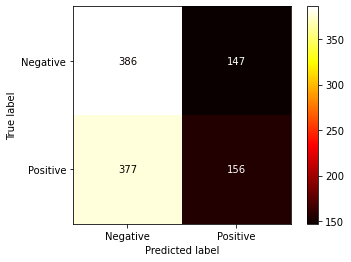

In [34]:
preds_zeroshot = test_zeroshot.predictions.argmax(-1)
actual_zeroshot = test_zeroshot.label_ids

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
# tn, fp, fn, tp
confusion_matrix_zeroshot = metrics.confusion_matrix(actual_zeroshot, preds_zeroshot)

cm_display_zeroshot = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_zeroshot, display_labels = ["Negative", "Positive"])

# Choose different colors: https://matplotlib.org/stable/tutorials/colors/colormaps.html
cm_display_zeroshot.plot(cmap='hot')
# cm_display.plot(cmap='inferno')
# cm_display.plot(cmap='gray')
# cm_display.plot(cmap='Reds')
# cm_display.plot(cmap='binary')
# cm_display.plot(cmap='flag')
plt.show()

#### Training Loop

In [35]:
# 8530 training examples
# 8530/16 -> np.ceil -> 534 -> 534 * 3 epochs = 1602 steps total.
# 8530/8 -> np.ceil -> 3201 -> 3201 * 3 epochs = 3201 steps total.
trainer.train()

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.393600
1000,0.190500
1500,0.073500


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=1602, training_loss=0.20900204089399282, metrics={'train_runtime': 268.9849, 'train_samples_per_second': 95.135, 'train_steps_per_second': 5.956, 'total_flos': 1025732282655600.0, 'train_loss': 0.20900204089399282, 'epoch': 3.0})

#### Save your model

In [36]:
dtg_save = time.strftime(f'%d%H%M%b%y').upper() #ex. '112036OCT21' ... add spaces for readability if desired
output_model = f"rot_tom_finetuned_model_{dtg_save}"
# model.save_pretrained(output_model)
trainer.save_model(output_model)

### Test your model

In [37]:
test_out = trainer.predict(test_dataset=test_dataset)

**Examine the elements of your test output**

In [38]:
test_out

PredictionOutput(predictions=array([[-3.0423584,  2.3060763],
       [-4.829594 ,  3.823728 ],
       [ 3.5852227, -2.2706015],
       ...,
       [ 4.264276 , -2.9400902],
       [ 4.2285147, -2.953429 ],
       [ 3.886257 , -2.676556 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 0, 0]), metrics={'test_loss': 0.7923239469528198, 'test_accuracy': 0.8574108818011257, 'test_f1': 0.8579439252336448, 'test_precision': 0.8547486033519553, 'test_recall': 0.8611632270168855, 'test_runtime': 4.3562, 'test_samples_per_second': 244.711, 'test_steps_per_second': 15.381})

**Verify the number of positive/negative predictions**

In [39]:
test_out.predictions.argmax(-1)

array([1, 1, 0, ..., 0, 0, 0])

In [40]:
# Count all _predicted_ "Positive" classifications
np.count_nonzero(test_out.predictions.argmax(-1))

537

**Make a confusion matrix**

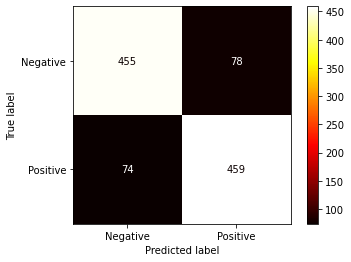

In [41]:
# https://en.wikipedia.org/wiki/Confusion_matrix

# Our plot shows:
# True Negative, False Positive
# False Negative, True Positive

# https://www.w3schools.com/python/python_ml_confusion_matrix.asp

preds = test_out.predictions.argmax(-1)
actual = test_out.label_ids

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
# tn, fp, fn, tp
results_confusion_matrix = metrics.confusion_matrix(actual, preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=results_confusion_matrix, display_labels = ["Negative", "Positive"])

# Choose different colors: https://matplotlib.org/stable/tutorials/colors/colormaps.html
cm_display.plot(cmap='hot')
# cm_display.plot(cmap='inferno')
# cm_display.plot(cmap='gray')
# cm_display.plot(cmap='Reds')
# cm_display.plot(cmap='binary')
# cm_display.plot(cmap='flag')
plt.show()

**Examine misclassified examples**

In [42]:
# create array of indices in test_dataset where examples were misclassified
# sum of any misclassified example in a binary classification == 1
misclassified = np.argwhere((actual+preds)==1).reshape(-1)
print(misclassified[:4],misclassified[-1:-5:-1])

print('Positive misclassified as negative:')
print('===================================')
for i,ex in enumerate(np.concatenate((misclassified[:4],misclassified[-1:-5:-1]))):
    if i == 4: 
        print('\nNegative misclassified as positive:')
        print('===================================\n')
    print(rt['test'][int(ex)]) # cast np.int64 as int

[ 2 14 22 28] [1056 1039 1029 1019]
Positive misclassified as negative:
{'text': 'it\'s like a " big chill " reunion of the baader-meinhof gang , only these guys are more harmless pranksters than political activists .', 'label': 1}
{'text': 'at its worst , the movie is pretty diverting ; the pity is that it rarely achieves its best .', 'label': 1}
{'text': "grown-up quibbles are beside the point here . the little girls understand , and mccracken knows that's all that matters .", 'label': 1}
{'text': 'devotees of star trek ii : the wrath of khan will feel a nagging sense of deja vu , and the grandeur of the best next generation episodes is lacking .', 'label': 1}

Negative misclassified as positive:

{'text': 'though excessively tiresome , the uncertainty principle , as verbally pretentious as the title may be , has its handful of redeeming features , as long as you discount its ability to bore .', 'label': 0}
{'text': "a film that plays things so nice 'n safe as to often play like a mi

**Test saved model**

In [43]:
load_model_path = output_model #TODO change if you have a different model to load
model2 = BertForSequenceClassification.from_pretrained(load_model_path)

trainer2 = Trainer(
    model=model2,    # ONLY PARAMETER CHANGED WAS THE MODEL.  IT WILL NOW USE THE MODEL FINE-TUNED ON ROTTEN TOMATOES
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [44]:
test_out2 = trainer2.predict(test_dataset=test_dataset)
print(test_out2)

PredictionOutput(predictions=array([[-3.0423584,  2.3060763],
       [-4.829594 ,  3.823728 ],
       [ 3.5852227, -2.2706015],
       ...,
       [ 4.264276 , -2.9400902],
       [ 4.2285147, -2.953429 ],
       [ 3.886257 , -2.676556 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 0, 0]), metrics={'test_loss': 0.7923239469528198, 'test_accuracy': 0.8574108818011257, 'test_f1': 0.8579439252336448, 'test_precision': 0.8547486033519553, 'test_recall': 0.8611632270168855, 'test_runtime': 4.2463, 'test_samples_per_second': 251.04, 'test_steps_per_second': 15.778})


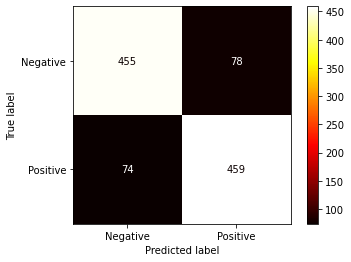

In [45]:
preds = test_out2.predictions.argmax(-1)
actual = test_out2.label_ids

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
# tn, fp, fn, tp
results_confusion_matrix = metrics.confusion_matrix(actual, preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=results_confusion_matrix, display_labels = ["Negative", "Positive"])

# Choose different colors: https://matplotlib.org/stable/tutorials/colors/colormaps.html
cm_display.plot(cmap='hot')
plt.show()

**Discussion of logits vs. softmax**  
[(https://huggingface.co/course/chapter2/2?fw=tf#postprocessing-the-output)

In [46]:
# https://huggingface.co/course/chapter2/2?fw=tf#postprocessing-the-output
# alternatively use softmax before argmax, since 'logits' are "the raw, unnormalized scores outputted by the last layer of the model"
#    Additional notes:
#         "all 🤗 Transformers models output the logits, as the loss function for training will generally fuse the last activation function, such as SoftMax, 
#         with the actual loss function, such as cross entropy"

In [47]:
scipy.special.softmax(test_out2.predictions, axis = -1)

array([[4.7330805e-03, 9.9526691e-01],
       [1.7451555e-04, 9.9982554e-01],
       [9.9714494e-01, 2.8549996e-03],
       ...,
       [9.9925739e-01, 7.4278109e-04],
       [9.9924016e-01, 7.5961102e-04],
       [9.9859005e-01, 1.4099173e-03]], dtype=float32)

In [48]:
test_out2.predictions

array([[-3.0423584,  2.3060763],
       [-4.829594 ,  3.823728 ],
       [ 3.5852227, -2.2706015],
       ...,
       [ 4.264276 , -2.9400902],
       [ 4.2285147, -2.953429 ],
       [ 3.886257 , -2.676556 ]], dtype=float32)

In [49]:
test_out2.predictions.argmax(-1)

array([1, 1, 0, ..., 0, 0, 0])

### Test new data classification

In [50]:
MODEL_PATH = output_model
model3 = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
config3 = AutoConfig.from_pretrained(MODEL_PATH)

In [51]:
new_text = 'This movie makes my eyeballs ache and my ears bleed.'
# new_text = 'I truly found my happy place while consuming this film.'
new_text = tokenizer(new_text, truncation=True, padding=True, return_tensors='pt')

In [52]:
with torch.no_grad():
    logits = model3(**new_text).logits

In [53]:
logits.softmax(dim=-1).flatten()

tensor([9.9949e-01, 5.1401e-04])

In [54]:
for i,prob in enumerate(logits.softmax(dim=-1).flatten()):
    print(f'* {config3.id2label[i].capitalize()}: {np.round(prob.item()*100,3)} %')

* Negative: 99.949 %
* Positive: 0.051 %
